## 🗑️ **Problem Definition: Garbage Classification**

**1)Proper waste management is essential for protecting the environment and improving recycling efficiency. However, many people struggle to correctly identify the appropriate bin for different types of waste. Misclassification leads to contamination, increased processing costs, and reduced recycling effectiveness.**

**2)This project aims to solve this problem by building an automated waste classification system that can identify the category of waste—such as plastic, metal, glass, paper, organic, or e-waste—based on an input image. Using machine learning and computer vision techniques, the system learns to recognize visual features in objects and assign them to the correct recycling bin.**

**3)The final goal is to develop a model that:**

**Accurately classifies waste into predefined categories**


<div style="text-align:center;">
    <img src="https://img.freepik.com/free-vector/garbage-sorting-set_74855-15415.jpg?semt=ais_hybrid&w=740&q=80"
         style="width:600%; height:700px; object-fit:contain;">
</div>


### **Importing Libraries**


In [1]:
import os
import torch
import torchvision
import random
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
from collections import Counter
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

### **Reading Data**


In [2]:
data_dir = r"G:\Hesham_DL\Transfer Learning\Garbage_Data\Garbage classification\Garbage classification"

classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


### **Transformations**


In [ ]:
transformations = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform=transformations)

In [4]:
labels = dataset.targets

count_per_class = Counter(labels)

for i, class_name in enumerate(dataset.classes):
    print(f"{class_name:<10} → {count_per_class[i]} samples")

print("="*25)

total_samples = sum(count_per_class.values())
print("Total samples:", total_samples)

cardboard  → 403 samples
glass      → 501 samples
metal      → 410 samples
paper      → 594 samples
plastic    → 482 samples
trash      → 137 samples
Total samples: 2527


### **Display Random Images**


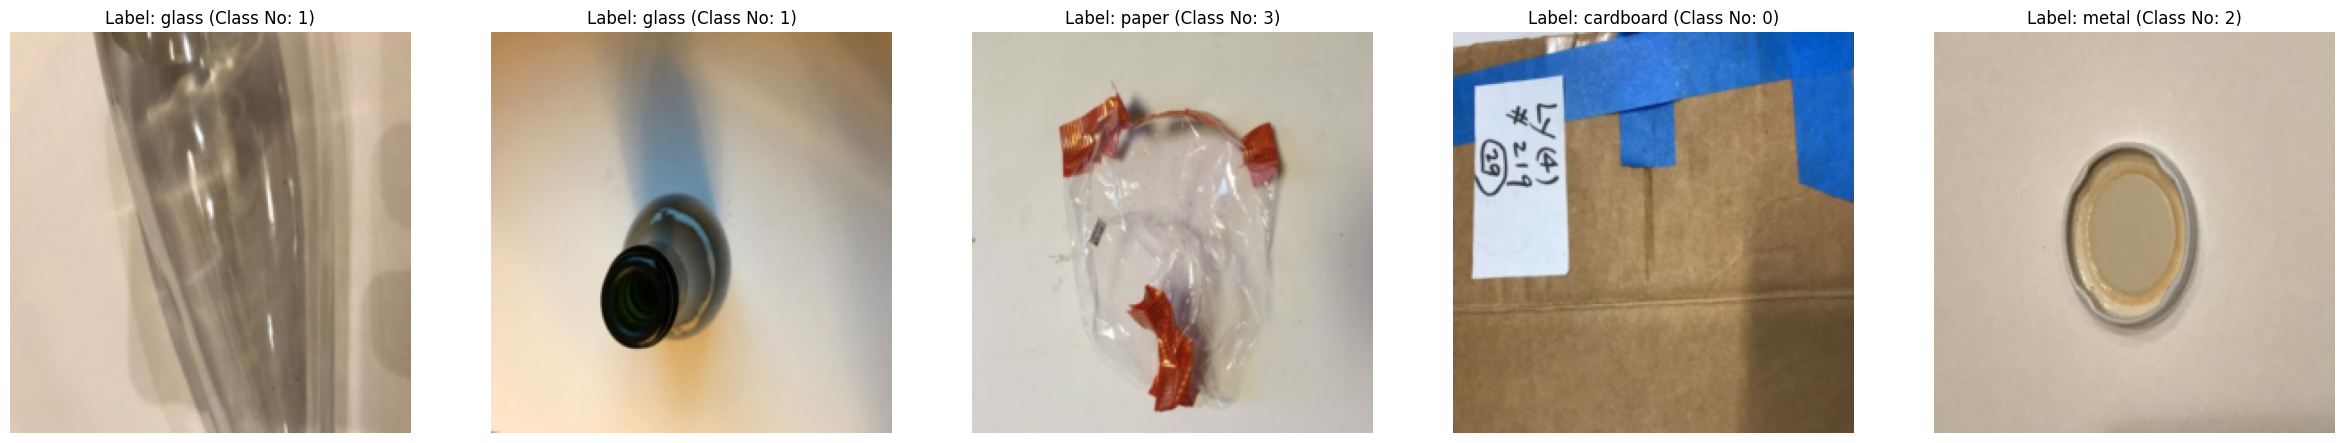

In [5]:
def show_random_samples(num_samples):
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(6 * num_samples, 6))

    for i, idx in enumerate(indices):
        img, label = dataset[idx]

        title = f"Label: {dataset.classes[label]} (Class No: {label})"

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(title)
        plt.axis("off")

    plt.show()


show_random_samples(5)

### **Loading and Splitting Data**


In [6]:
torch.manual_seed(42)
total = len(dataset)

train_size = int(0.70 * total)               # 70%
val_size = int(0.15 * total)              # 15%
test_size = total - train_size - val_size  # 15%

train_ds, val_ds, test_ds = random_split(
    dataset, [train_size, val_size, test_size])


len(train_ds), len(val_ds), len(test_ds)

(1768, 379, 380)

In [ ]:
batch_size = 32

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

val_loader = DataLoader(val_ds, batch_size=batch_size,
                        shuffle=False, pin_memory=True)

test_loader = DataLoader(test_ds, batch_size=batch_size,
                         shuffle=False, pin_memory=True)

### **Visualize batches**


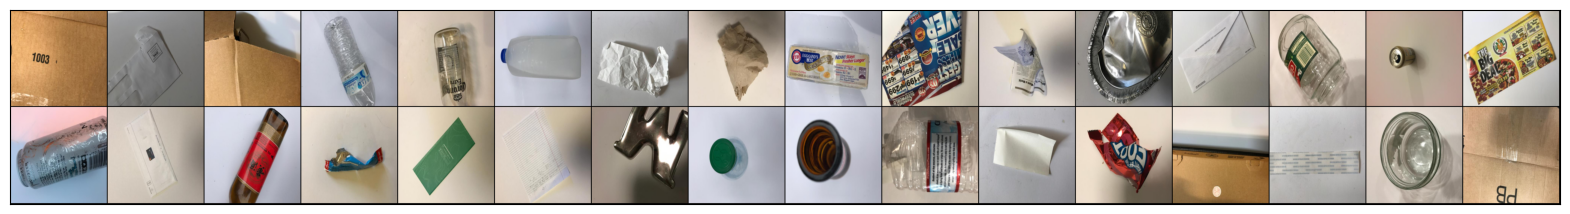

In [8]:
from torchvision.utils import make_grid


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


# Every Batch from train_loader  Display 32 Picture , we have 55 batch
show_batch(train_loader)

### **Model Base**


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result, is_best=False):
        msg = (
            f"Epoch {epoch} | "
            f"Train Acc: {result['train_acc']:.4f} | "
            f"Train Loss: {result['train_loss']:.4f} | "
            f"Val Loss: {result['val_loss']:.4f} | "
            f"Val Acc: {result['val_acc']:.4f}"
        )
        if is_best:
            msg += "  <-- Saving best model "
        print(msg)

### **We'll be using ResNet50 for classifying images**


In [ ]:
import torch.nn as nn
import torchvision.models as models


class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.resnet50(pretrained=True)

        # Get number of features of last FC layer
        num_ftrs = self.network.fc.in_features

        # Add Dropout before the final layer
        self.network.fc = nn.Sequential(
            nn.Dropout(p=0.2),               # Dropout probability (20%)
            nn.Linear(num_ftrs, len(dataset.classes))
        )

    def forward(self, xb):
        return self.network(xb)

### **Run On GPU if available**


In [11]:
import torch

# 1) Select the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2) Create the model and move it to the selected device
model = ResNet()
model = model.to(device)

Using device: cuda


c:\envs\torch311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\envs\torch311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **Optimizer**


In [ ]:
import torch.optim as optim
opt_func = torch.optim.SGD

optimizer = opt_func(
    model.parameters(),
    lr=1e-3,
    momentum=0.9,
    weight_decay=1e-4
)

### **Fitting Model**


In [ ]:
import torch
import torch.nn.functional as F


def fit(epochs, model, train_loader, val_loader, optimizer, device, checkpoint_path="best_model.pth"):
    history = []
    best_val_acc = 0.0  # to track the best validation accuracy

    for epoch in range(epochs):
        # --------- TRAINING ---------
        model.train()
        train_losses = []
        train_correct = 0
        train_total = 0

        for batch in train_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            # ONE forward pass only
            outputs = model(images)

            # loss (same as training_step was doing)
            loss = F.cross_entropy(outputs, labels)
            train_losses.append(loss)

            # train accuracy from the same outputs
            _, preds = torch.max(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            # backward + optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss = torch.stack(train_losses).mean().item()
        train_acc = train_correct / train_total

        # --------- VALIDATION ---------
        model.eval()
        with torch.no_grad():
            val_outputs = []
            for batch in val_loader:
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)

                out = model.validation_step((images, labels))
                val_outputs.append(out)

            result = model.validation_epoch_end(val_outputs)
            result['train_loss'] = train_loss
            result['train_acc'] = train_acc

        # --------- CHECK IF NEW BEST ---------
        val_acc = result['val_acc']
        is_best = val_acc > best_val_acc

        # --------- PRINT EPOCH RESULT ---------
        model.epoch_end(epoch + 1, result, is_best=is_best)
        history.append(result)

        # --------- CHECKPOINTING ---------
        if is_best:
            best_val_acc = val_acc
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_loss": result['val_loss'],
                    "val_acc": result['val_acc'],
                },
                checkpoint_path,
            )

    return history

In [ ]:
epochs = 20
history = fit(epochs, model, train_loader, val_loader, optimizer,
              device, checkpoint_path="best_model.pth")

Epoch 1 | Train Acc: 0.5368 | Train Loss: 1.2413 | Val Loss: 0.7592 | Val Acc: 0.7421  <-- Saving best model 
Epoch 2 | Train Acc: 0.8439 | Train Loss: 0.4850 | Val Loss: 0.4937 | Val Acc: 0.8345  <-- Saving best model 
Epoch 3 | Train Acc: 0.9361 | Train Loss: 0.2477 | Val Loss: 0.3975 | Val Acc: 0.8662  <-- Saving best model 
Epoch 4 | Train Acc: 0.9723 | Train Loss: 0.1358 | Val Loss: 0.3517 | Val Acc: 0.8792  <-- Saving best model 
Epoch 5 | Train Acc: 0.9813 | Train Loss: 0.1053 | Val Loss: 0.3099 | Val Acc: 0.8871  <-- Saving best model 
Epoch 6 | Train Acc: 0.9898 | Train Loss: 0.0627 | Val Loss: 0.3945 | Val Acc: 0.8584
Epoch 7 | Train Acc: 0.9938 | Train Loss: 0.0508 | Val Loss: 0.2800 | Val Acc: 0.9105  <-- Saving best model 
Epoch 8 | Train Acc: 0.9966 | Train Loss: 0.0337 | Val Loss: 0.3228 | Val Acc: 0.8871
Epoch 9 | Train Acc: 0.9983 | Train Loss: 0.0236 | Val Loss: 0.2690 | Val Acc: 0.9058
Epoch 10 | Train Acc: 0.9983 | Train Loss: 0.0220 | Val Loss: 0.2647 | Val Acc: 0.

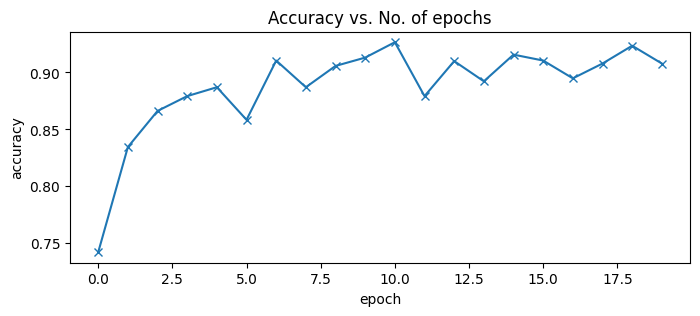

In [ ]:
plt.figure(figsize=(8, 3))


def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')


plot_accuracies(history)

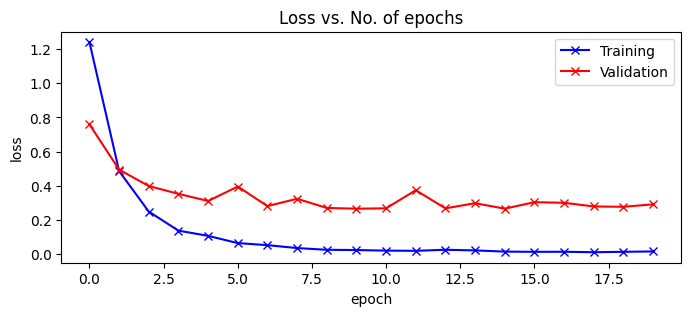

In [ ]:
plt.figure(figsize=(8, 3))


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')


plot_losses(history)

In [39]:
checkpoint = torch.load("best_model.pth", map_location=device)
model = ResNet().to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# evaluate on test_loader
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("="*30)
print(f"Test Acc: {correct/total*100:.3f}%")
print("="*30)

C:\Users\dell\AppData\Local\Temp\ipykernel_17456\1274881765.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", map_location=device

Test Acc: 93.421%


### **Visualizing Predictions**


In [ ]:
def predict_image(img, model):
    # Convert image to batch of size 1
    xb = img.unsqueeze(0).to(device)

    # Get predictions
    yb = model(xb)

    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)

    # Return class label
    return dataset.classes[preds[0].item()]

In [ ]:
def show_predictions_grid(images, labels, model, rows=2, cols=3):
    plt.figure(figsize=(3 * cols, 3 * rows))

    for i in range(len(images)):
        img = images[i]
        label = labels[i]
        pred = predict_image(img, model)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Label: {label}\nPredicted: {pred}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

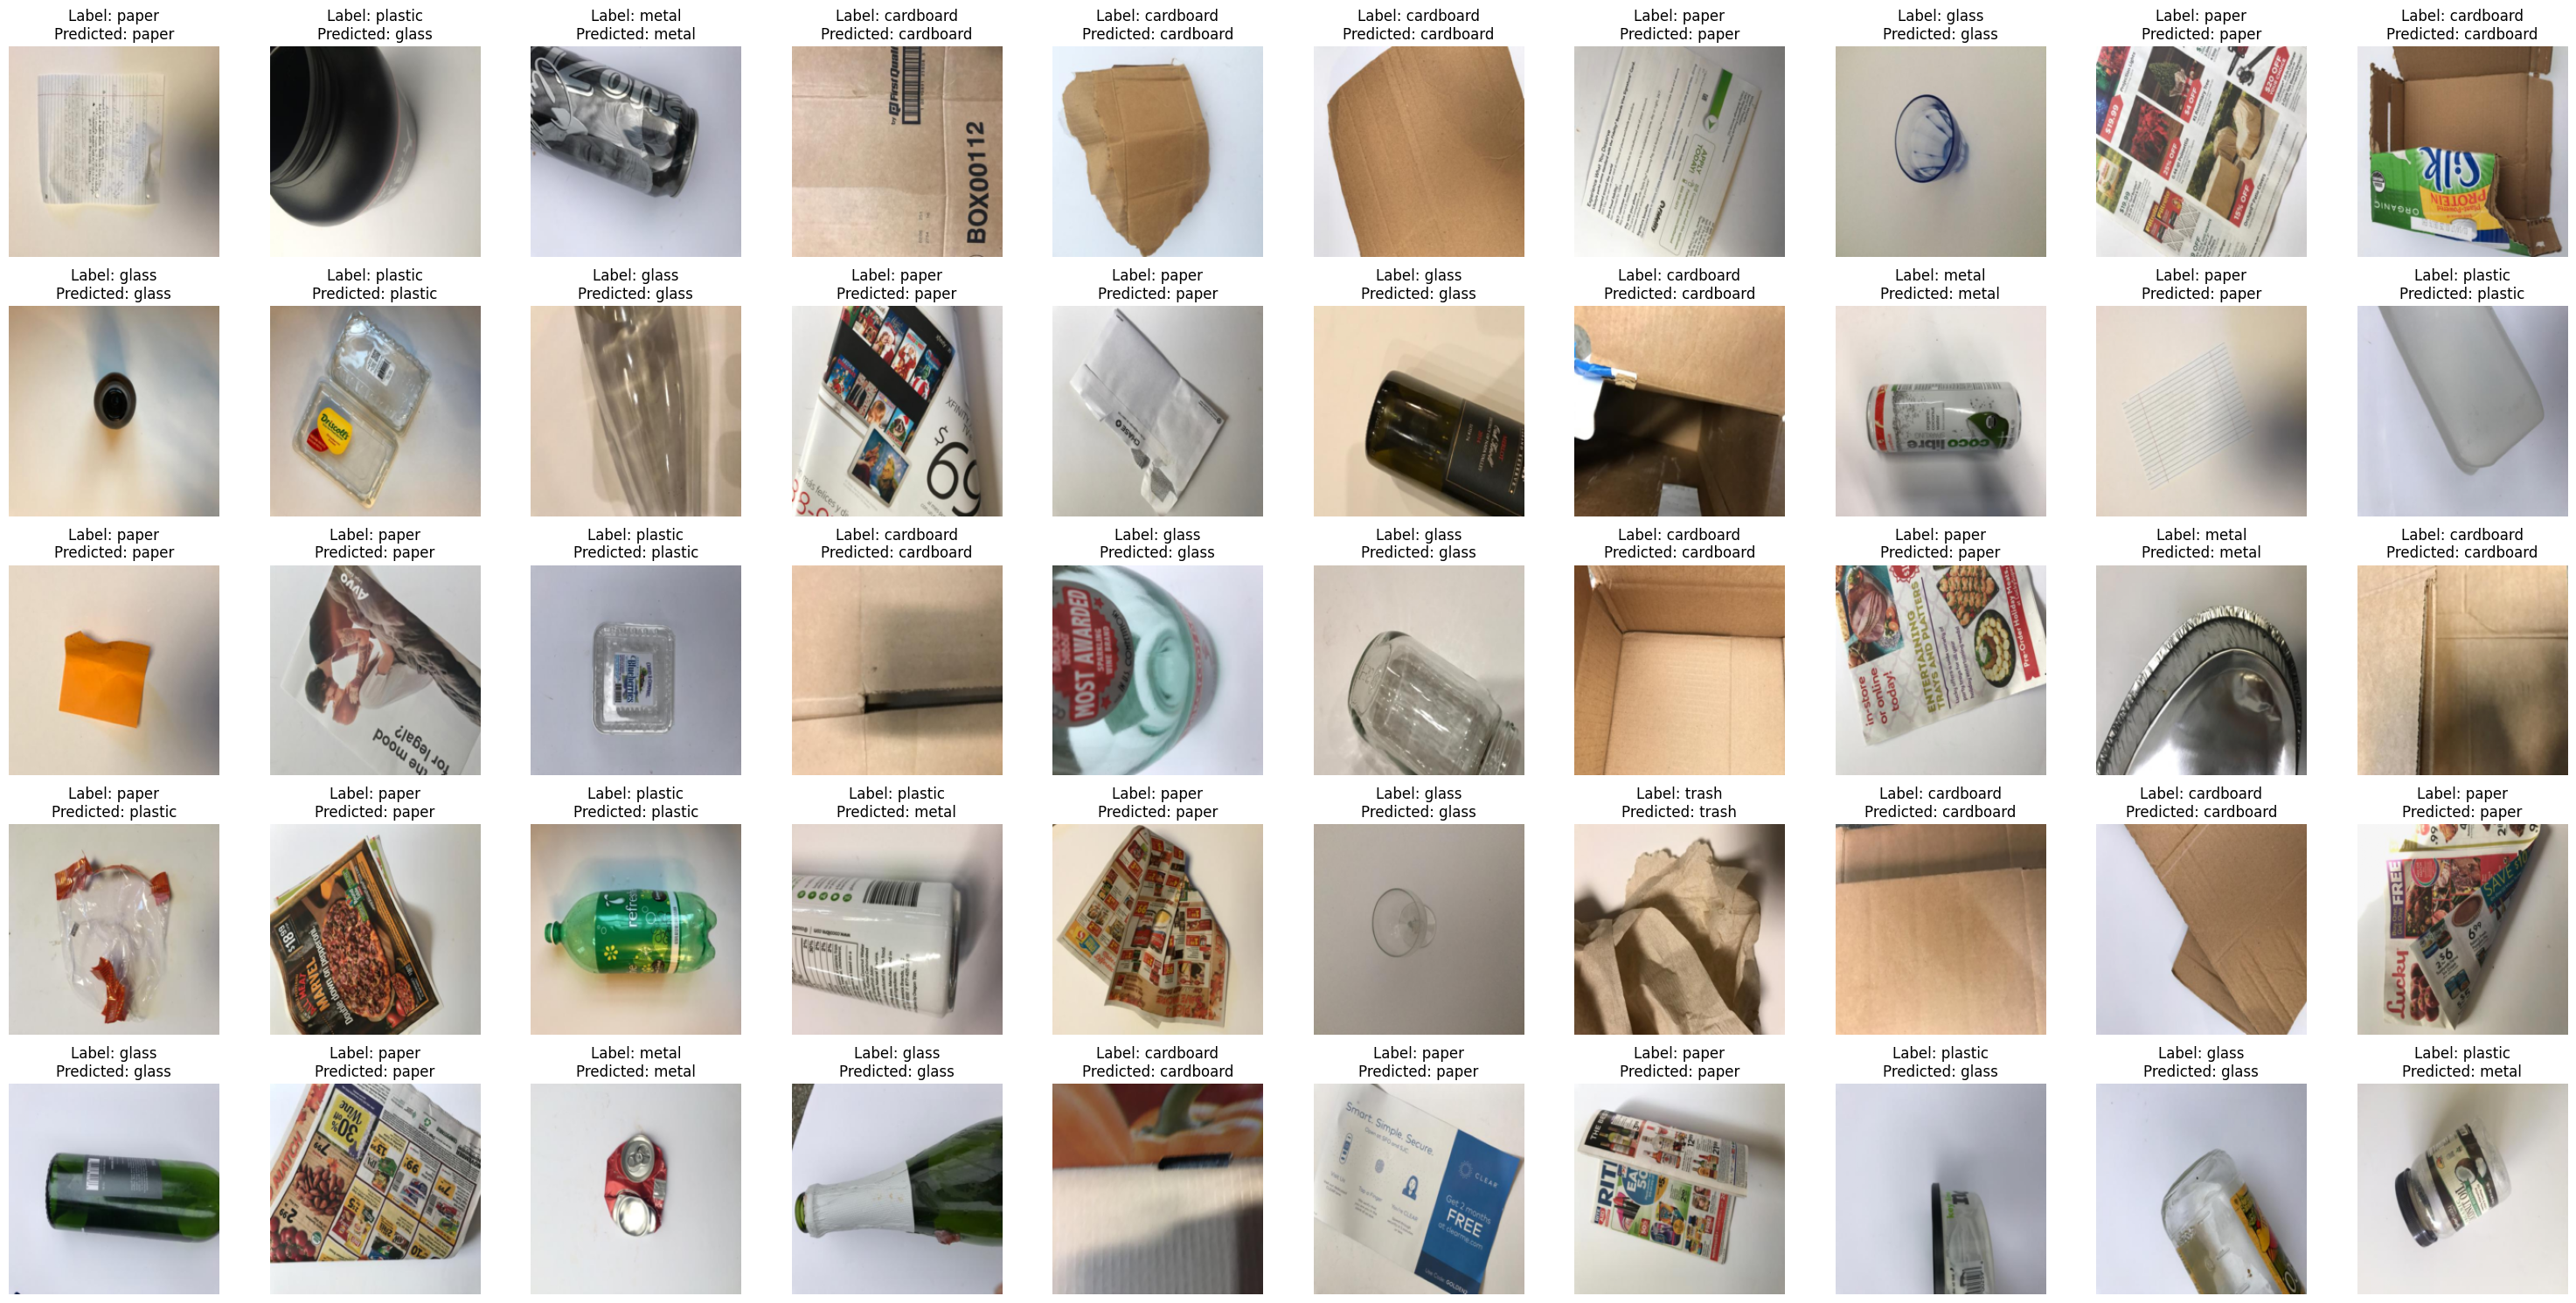

In [ ]:
def fetch_samples(loader, n=50):
    imgs, lbls = [], []

    for images, labels in loader:
        imgs.extend(images)
        lbls.extend(labels)

        if len(imgs) >= n:
            break

    imgs = imgs[:n]
    lbls = [dataset.classes[l.item()] for l in lbls[:n]]

    return imgs, lbls


# -------- Display 50 images --------
imgs, lbls = fetch_samples(test_loader, n=50)

show_predictions_grid(imgs, lbls, model, rows=5, cols=10)